# Import Libraries

In [ ]:
# For drive access
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import numpy as np
import pandas as pd

# for loading the pickle files with features and labels
import pickle

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


# Load features and labels from train and val pickle

In [ ]:
with open('/content/drive/MyDrive/project/train_val_features_pkl/train_val_8_sec_augmented_audio_features_avgpooled.pkl', 'rb') as file:
  audio_df = pickle.load(file)

In [ ]:
audio_df

{'train': {'mfcc': array([[0.44627464, 0.45426083, 0.5378976 , ..., 0.41270763, 0.49669155,
          0.44323295],
         [0.4870945 , 0.3999269 , 0.53268594, ..., 0.38443726, 0.49417073,
          0.46917754],
         [0.48996815, 0.39159116, 0.5386251 , ..., 0.38565   , 0.4793156 ,
          0.46398744],
         ...,
         [0.5851718 , 0.67896426, 0.5308942 , ..., 0.53540635, 0.5450823 ,
          0.5205621 ],
         [0.57395256, 0.68371713, 0.53624344, ..., 0.5139698 , 0.5373012 ,
          0.48929185],
         [0.55954564, 0.6784133 , 0.52643305, ..., 0.5064577 , 0.5295971 ,
          0.48355782]], dtype=float32),
  'chroma': array([[0.37101182, 0.32926235, 0.27844787, ..., 0.45568615, 0.62949955,
          0.51872045],
         [0.35346994, 0.29351434, 0.27224222, ..., 0.4687016 , 0.5994445 ,
          0.5020444 ],
         [0.312296  , 0.30661365, 0.33116865, ..., 0.5022151 , 0.53005433,
          0.38759488],
         ...,
         [0.6334156 , 0.69854987, 0.7787965 , 

In [ ]:
with open('/content/drive/MyDrive/project/train_val_features_pkl/train_val_8_sec_augmented_non_audio_features.pkl', 'rb') as file:
  non_audio_df = pickle.load(file)

In [ ]:
non_audio_df

{'train': {'type': array(['blank', 'blank', 'blank', ..., 'blank', 'blank', 'blank'],
        dtype='<U5'),
  'continent': array(['AFRICA', 'AFRICA', 'AFRICA', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([5., 5., 5., ..., 5., 5., 5.]),
  'label': array([0, 0, 0, ..., 2, 2, 2])},
 'val': {'type': array(['song', 'call', 'call', ..., 'blank', 'call', 'call'], dtype='<U5'),
  'continent': array(['EUROPE', 'EUROPE', 'EUROPE', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([3.5, 5. , 4. , ..., 5. , 3. , 3. ]),
  'label': array([0, 0, 1, ..., 2, 1, 2])}}

## confirm the audio features and non_audio features labels line-up

In [ ]:
assert np.array_equal(audio_df['train']['label'], non_audio_df['train']['label'])

In [ ]:
assert np.array_equal(audio_df['val']['label'], non_audio_df['val']['label'])

# Shuffle the data

In [ ]:
def shuffle_data(audio_features, non_audio_features):
  input_len = len(audio_features['label'])
  input_indices = np.random.permutation(input_len)
  audio_features = {key: np.array([audio_features[key][i] for i in input_indices]) for key in audio_features}
  non_audio_features = {key: np.array([non_audio_features[key][i] for i in input_indices]) for key in non_audio_features}

  return audio_features, non_audio_features

In [ ]:
audio_df['train'], non_audio_df['train'] = shuffle_data(audio_df['train'], non_audio_df['train'])

In [ ]:
for key in audio_df['train'].keys():
  display(key)
  display(audio_df['train'][key].shape)
  display(audio_df['train'][key][:5])

'mfcc'

(4763, 20)

array([[0.34820727, 0.48184183, 0.6461114 , 0.67517823, 0.57057154,
        0.48465237, 0.5506952 , 0.4863203 , 0.58699536, 0.55382675,
        0.5810943 , 0.610325  , 0.528491  , 0.5128172 , 0.552036  ,
        0.45687807, 0.51731306, 0.52339005, 0.59905005, 0.48694566],
       [0.6440424 , 0.45292035, 0.6263944 , 0.60982746, 0.5923047 ,
        0.5069874 , 0.6787132 , 0.47068772, 0.5980804 , 0.5886977 ,
        0.5477655 , 0.5630138 , 0.56122404, 0.57451826, 0.50606644,
        0.5287906 , 0.5197042 , 0.5047255 , 0.56472087, 0.468493  ],
       [0.4642789 , 0.5191033 , 0.47646573, 0.4691456 , 0.44448107,
        0.52092755, 0.4577293 , 0.28859377, 0.35233438, 0.42862052,
        0.36389673, 0.483184  , 0.33893386, 0.47505563, 0.40930226,
        0.381269  , 0.40611988, 0.4927823 , 0.45673034, 0.4301965 ],
       [0.5809628 , 0.5963421 , 0.5500673 , 0.5632408 , 0.59456056,
        0.60176593, 0.6442308 , 0.5072062 , 0.6167339 , 0.53402543,
        0.54758084, 0.5829047 , 0.5019837 , 0

'chroma'

(4763, 12)

array([[0.31880113, 0.347018  , 0.34556788, 0.41971347, 0.3465736 ,
        0.2852126 , 0.30413374, 0.36670148, 0.40018508, 0.32982287,
        0.27211753, 0.26353404],
       [0.42101726, 0.43254265, 0.4255878 , 0.44732097, 0.5372371 ,
        0.5754685 , 0.6167253 , 0.6844002 , 0.61782926, 0.5029362 ,
        0.42173085, 0.37840915],
       [0.35170138, 0.3350962 , 0.38666502, 0.48265958, 0.44449133,
        0.43258673, 0.44910765, 0.48402405, 0.48303926, 0.403861  ,
        0.32589912, 0.32983282],
       [0.49401334, 0.49040702, 0.50716835, 0.51187414, 0.47640705,
        0.5750985 , 0.670369  , 0.6964049 , 0.69324094, 0.60397947,
        0.5167144 , 0.5045472 ],
       [0.6366039 , 0.691783  , 0.73006386, 0.685383  , 0.67156464,
        0.7017032 , 0.6978027 , 0.6718362 , 0.6517209 , 0.62471855,
        0.5955074 , 0.6249628 ]], dtype=float32)

'rms'

(4763, 1)

array([[0.03010871],
       [0.04310095],
       [0.01226025],
       [0.03455144],
       [0.01946499]], dtype=float32)

'spectral_centroid'

(4763, 1)

array([[0.5348336 ],
       [0.6005906 ],
       [0.513116  ],
       [0.41658676],
       [0.2713957 ]], dtype=float32)

'melspectrogram'

(4763, 20)

array([[0.49377877, 0.39760292, 0.37509203, 0.40200797, 0.3702106 ,
        0.3096737 , 0.30316657, 0.3099859 , 0.34478024, 0.3681062 ,
        0.38977823, 0.42820197, 0.43934342, 0.41251412, 0.42467165,
        0.41253814, 0.4205548 , 0.39508733, 0.38260147, 0.33644804],
       [0.67453784, 0.5866982 , 0.5616628 , 0.57016635, 0.57274276,
        0.5749534 , 0.5888396 , 0.6007873 , 0.62361246, 0.6350596 ,
        0.62940395, 0.6515871 , 0.6819467 , 0.6904826 , 0.6666914 ,
        0.6419989 , 0.6385458 , 0.6141897 , 0.64370984, 0.63254166],
       [0.4703445 , 0.4982434 , 0.49582908, 0.48849392, 0.48648205,
        0.5027536 , 0.55477166, 0.57644254, 0.58594185, 0.56113774,
        0.4892075 , 0.49035713, 0.48740274, 0.47455975, 0.49642313,
        0.47790924, 0.46279866, 0.45155504, 0.44082302, 0.39136806],
       [0.68893284, 0.5978517 , 0.56525123, 0.572017  , 0.5920379 ,
        0.60761225, 0.6305818 , 0.6403731 , 0.64155746, 0.6289061 ,
        0.60402846, 0.58485705, 0.5647485 , 0

'label'

(4763,)

array([2, 0, 2, 2, 2])

In [ ]:
for key in non_audio_df['train'].keys():
  display(key)
  display(non_audio_df['train'][key].shape)
  display(non_audio_df['train'][key][:5])

'type'

(4763,)

array(['song', 'both', 'both', 'song', 'blank'], dtype='<U5')

'continent'

(4763,)

array(['ASIA', 'AMERICAS', 'EUROPE', 'EUROPE', 'EUROPE'], dtype='<U8')

'rating'

(4763,)

array([5. , 5. , 3.5, 4. , 5. ])

'label'

(4763,)

array([2, 0, 2, 2, 2])

In [ ]:
audio_df['val'], non_audio_df['val'] = shuffle_data(audio_df['val'], non_audio_df['val'])

In [ ]:
for key in audio_df['val'].keys():
  display(key)
  display(audio_df['val'][key].shape)
  display(audio_df['val'][key][:5])

'mfcc'

(2430, 20)

array([[0.4809289 , 0.48404783, 0.4614303 , 0.48904362, 0.48137632,
        0.3821809 , 0.6006535 , 0.3760934 , 0.50778174, 0.46782848,
        0.505665  , 0.5553976 , 0.5106435 , 0.5778062 , 0.60456824,
        0.598191  , 0.5732399 , 0.54665196, 0.5895821 , 0.5255967 ],
       [0.52836245, 0.4776704 , 0.37530428, 0.4272036 , 0.32365653,
        0.36203167, 0.3530962 , 0.33895668, 0.31128845, 0.31964582,
        0.3319606 , 0.4221069 , 0.43283877, 0.41002655, 0.5125367 ,
        0.32499695, 0.48605084, 0.428662  , 0.5695936 , 0.49824807],
       [0.7011306 , 0.7296374 , 0.42718813, 0.57752144, 0.55170333,
        0.46338496, 0.50980675, 0.49468827, 0.5088208 , 0.39150378,
        0.47022438, 0.46521237, 0.40842324, 0.4347768 , 0.45550022,
        0.4309382 , 0.43339336, 0.48408222, 0.44844702, 0.44203296],
       [0.5131824 , 0.40574303, 0.395477  , 0.29650354, 0.30414245,
        0.15311207, 0.39041305, 0.37026313, 0.48859903, 0.5698368 ,
        0.60483485, 0.68302554, 0.6079856 , 0

'chroma'

(2430, 12)

array([[0.4953553 , 0.50872433, 0.5323536 , 0.5286687 , 0.51925486,
        0.53333056, 0.6013801 , 0.67926466, 0.5843993 , 0.6026752 ,
        0.5844439 , 0.5068333 ],
       [0.23887707, 0.24249962, 0.3006453 , 0.38662055, 0.4647878 ,
        0.46625474, 0.3090521 , 0.23429343, 0.21664758, 0.2732252 ,
        0.38316128, 0.3078552 ],
       [0.7591979 , 0.71080333, 0.6769215 , 0.6586416 , 0.6351317 ,
        0.6393441 , 0.680458  , 0.7271231 , 0.7764314 , 0.76596546,
        0.71478146, 0.7406465 ],
       [0.44002602, 0.43681422, 0.44606715, 0.43169042, 0.47803515,
        0.5070415 , 0.45958698, 0.44969067, 0.44365594, 0.422056  ,
        0.42061216, 0.45159376],
       [0.3432502 , 0.28441298, 0.27345338, 0.2115997 , 0.23933327,
        0.28320292, 0.59438   , 0.49205717, 0.3690769 , 0.45489767,
        0.34667593, 0.3711361 ]], dtype=float32)

'rms'

(2430, 1)

array([[0.00820298],
       [0.01806734],
       [0.0407758 ],
       [0.03265107],
       [0.04405262]], dtype=float32)

'spectral_centroid'

(2430, 1)

array([[0.505941  ],
       [0.50134593],
       [0.22624998],
       [0.5746862 ],
       [0.47044596]], dtype=float32)

'melspectrogram'

(2430, 20)

array([[0.4351601 , 0.4388159 , 0.48237723, 0.47027716, 0.49757907,
        0.5242608 , 0.53801984, 0.54955995, 0.55394703, 0.53263175,
        0.53465325, 0.5496666 , 0.548488  , 0.534991  , 0.5124748 ,
        0.48653993, 0.45395592, 0.42133147, 0.43071166, 0.4305815 ],
       [0.41609687, 0.49877998, 0.53342366, 0.54704064, 0.55870026,
        0.59533286, 0.62993234, 0.6151802 , 0.6178016 , 0.61086166,
        0.6080582 , 0.61149144, 0.59579164, 0.5706735 , 0.5583355 ,
        0.5599327 , 0.53741187, 0.56695396, 0.51322293, 0.3904866 ],
       [0.7593011 , 0.77988636, 0.7575733 , 0.7543162 , 0.7730834 ,
        0.78302366, 0.7879342 , 0.7891658 , 0.78831303, 0.782893  ,
        0.7745111 , 0.7607577 , 0.6987175 , 0.60987145, 0.57524896,
        0.5388787 , 0.52354044, 0.46728382, 0.42231834, 0.38794464],
       [0.22647877, 0.32441387, 0.5625449 , 0.59620565, 0.59648824,
        0.59436834, 0.58259326, 0.58223563, 0.58489966, 0.576281  ,
        0.5741111 , 0.58540463, 0.58194864, 0

'label'

(2430,)

array([0, 1, 1, 2, 0])

In [ ]:
for key in non_audio_df['val'].keys():
  display(key)
  display(non_audio_df['val'][key].shape)
  display(non_audio_df['val'][key][:5])

'type'

(2430,)

array(['both', 'blank', 'call', 'both', 'song'], dtype='<U5')

'continent'

(2430,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'ASIA', 'AMERICAS'], dtype='<U8')

'rating'

(2430,)

array([3. , 4.5, 4. , 3.5, 3.5])

'label'

(2430,)

array([0, 1, 1, 2, 0])

# One Hot Encode Continents

In [ ]:
encoder = OneHotEncoder(sparse_output=False)

train_continents = non_audio_df['train']['continent'].reshape(-1, 1)
val_continents = non_audio_df['val']['continent'].reshape(-1, 1)

non_audio_df['train']['continent'] = encoder.fit_transform(train_continents)
non_audio_df['val']['continent'] = encoder.fit_transform(val_continents)

In [ ]:
display(non_audio_df['train']['continent'].shape)
display(non_audio_df['train']['continent'][:5])

display(non_audio_df['val']['continent'].shape)
display(non_audio_df['val']['continent'][:5])

(4763, 5)

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

(2430, 5)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

# SVM Models

In [ ]:
train_results = {}
val_results = {}

In [ ]:
classes = ['barswa', 'comsan', 'eaywag1']

## With all features

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'], audio_df['train']['rms'], audio_df['train']['spectral_centroid'], audio_df['train']['melspectrogram'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.34820727, 0.48184183, 0.64611143, ..., 1.        , 0.        ,
        0.        ],
       [0.64404237, 0.45292035, 0.62639439, ..., 0.        , 0.        ,
        0.        ],
       [0.46427891, 0.51910329, 0.47646573, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.62084126, 0.60520083, 0.62595576, ..., 1.        , 0.        ,
        0.        ],
       [0.67159772, 0.72349191, 0.40953511, ..., 0.        , 1.        ,
        0.        ],
       [0.78831404, 0.52622873, 0.58111882, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
training_features.shape

(4763, 59)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma'], audio_df['val']['rms'], audio_df['val']['spectral_centroid'], audio_df['val']['melspectrogram'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.4809289 , 0.48404783, 0.46143031, ..., 0.        , 1.        ,
        0.        ],
       [0.52836245, 0.4776704 , 0.37530428, ..., 0.        , 1.        ,
        0.        ],
       [0.70113063, 0.72963738, 0.42718813, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.47892618, 0.58912402, 0.59166372, ..., 0.        , 1.        ,
        0.        ],
       [0.42351782, 0.66250044, 0.61499703, ..., 0.        , 0.        ,
        0.        ],
       [0.68570822, 0.77514535, 0.51776344, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(2430, 59)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['all_features'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['all_features'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8935544824690321
Validation accuracy: 0.7226337448559671


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.94      0.86      0.90      1603
      comsan       0.92      0.90      0.91      1578
     eaywag1       0.83      0.92      0.87      1582

    accuracy                           0.89      4763
   macro avg       0.90      0.89      0.89      4763
weighted avg       0.90      0.89      0.89      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.83      0.71      0.77      1032
      comsan       0.67      0.74      0.70       618
     eaywag1       0.65      0.73      0.69       780

    accuracy                           0.72      2430
   macro avg       0.72      0.72      0.72      2430
weighted avg       0.73      0.72      0.72      2430



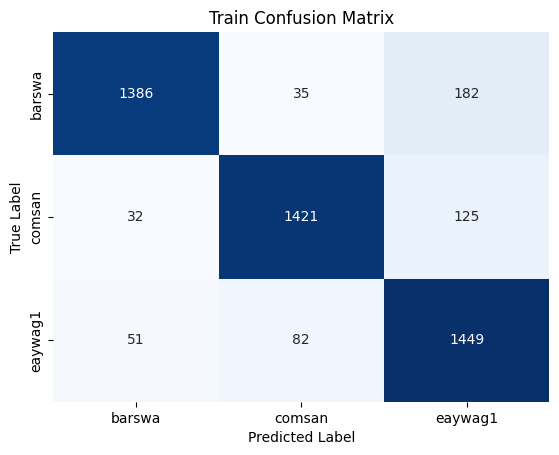

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

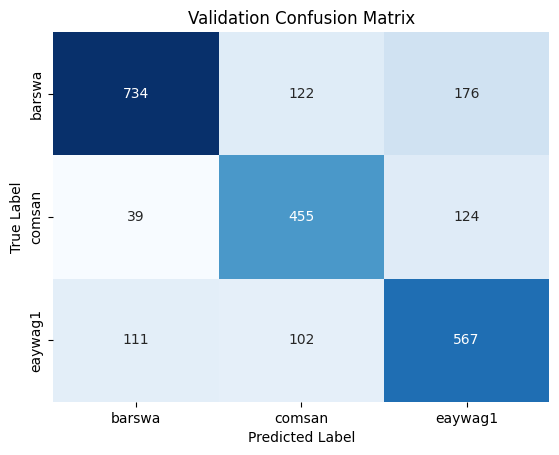

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only MFCC

### create features

In [ ]:
training_features = audio_df['train']['mfcc']

training_features

array([[0.34820727, 0.48184183, 0.6461114 , ..., 0.52339005, 0.59905005,
        0.48694566],
       [0.6440424 , 0.45292035, 0.6263944 , ..., 0.5047255 , 0.56472087,
        0.468493  ],
       [0.4642789 , 0.5191033 , 0.47646573, ..., 0.4927823 , 0.45673034,
        0.4301965 ],
       ...,
       [0.62084126, 0.6052008 , 0.62595576, ..., 0.51271445, 0.53306746,
        0.48378655],
       [0.6715977 , 0.7234919 , 0.4095351 , ..., 0.47123322, 0.40129334,
        0.4582841 ],
       [0.78831404, 0.5262287 , 0.5811188 , ..., 0.44754556, 0.56109846,
        0.44815272]], dtype=float32)

In [ ]:
training_features.shape

(4763, 20)

In [ ]:
validation_features = audio_df['val']['mfcc']

validation_features

array([[0.4809289 , 0.48404783, 0.4614303 , ..., 0.54665196, 0.5895821 ,
        0.5255967 ],
       [0.52836245, 0.4776704 , 0.37530428, ..., 0.428662  , 0.5695936 ,
        0.49824807],
       [0.7011306 , 0.7296374 , 0.42718813, ..., 0.48408222, 0.44844702,
        0.44203296],
       ...,
       [0.47892618, 0.589124  , 0.5916637 , ..., 0.482582  , 0.5463435 ,
        0.50978327],
       [0.42351782, 0.66250044, 0.614997  , ..., 0.38162166, 0.47088793,
        0.42415786],
       [0.6857082 , 0.77514535, 0.51776344, ..., 0.48317906, 0.5331603 ,
        0.4648098 ]], dtype=float32)

In [ ]:
validation_features.shape

(2430, 20)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.9317656938904052
Validation accuracy: 0.6308641975308642


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.95      0.90      0.92      1603
      comsan       0.96      0.94      0.95      1578
     eaywag1       0.89      0.96      0.92      1582

    accuracy                           0.93      4763
   macro avg       0.93      0.93      0.93      4763
weighted avg       0.93      0.93      0.93      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.68      0.61      0.65      1032
      comsan       0.65      0.69      0.67       618
     eaywag1       0.56      0.61      0.58       780

    accuracy                           0.63      2430
   macro avg       0.63      0.64      0.63      2430
weighted avg       0.63      0.63      0.63      2430



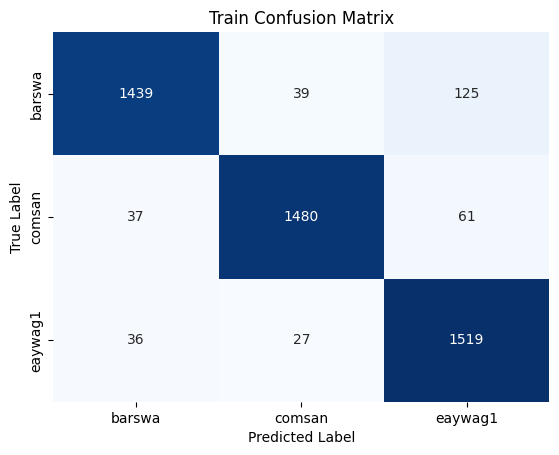

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

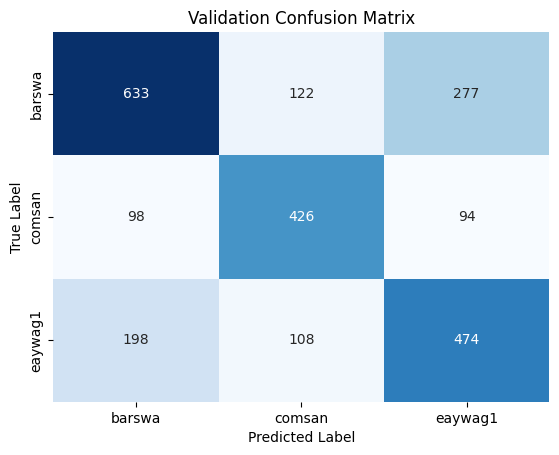

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only chroma

### create features

In [ ]:
training_features = audio_df['train']['chroma']

training_features

array([[0.31880113, 0.347018  , 0.34556788, ..., 0.32982287, 0.27211753,
        0.26353404],
       [0.42101726, 0.43254265, 0.4255878 , ..., 0.5029362 , 0.42173085,
        0.37840915],
       [0.35170138, 0.3350962 , 0.38666502, ..., 0.403861  , 0.32589912,
        0.32983282],
       ...,
       [0.6042192 , 0.6280736 , 0.6700558 , ..., 0.7229928 , 0.6785163 ,
        0.6189387 ],
       [0.7324639 , 0.64190096, 0.6239674 , ..., 0.7976932 , 0.7712831 ,
        0.77631885],
       [0.682571  , 0.7327003 , 0.825132  , ..., 0.77093816, 0.8106363 ,
        0.7499701 ]], dtype=float32)

In [ ]:
training_features.shape

(4763, 12)

In [ ]:
validation_features = audio_df['val']['chroma']

validation_features

array([[0.4953553 , 0.50872433, 0.5323536 , ..., 0.6026752 , 0.5844439 ,
        0.5068333 ],
       [0.23887707, 0.24249962, 0.3006453 , ..., 0.2732252 , 0.38316128,
        0.3078552 ],
       [0.7591979 , 0.71080333, 0.6769215 , ..., 0.76596546, 0.71478146,
        0.7406465 ],
       ...,
       [0.56624216, 0.55967504, 0.5448879 , ..., 0.63181746, 0.61438715,
        0.5792776 ],
       [0.49929467, 0.5199652 , 0.4153066 , ..., 0.57986253, 0.7078528 ,
        0.682594  ],
       [0.6252593 , 0.6550147 , 0.6015228 , ..., 0.5295637 , 0.55182225,
        0.6297107 ]], dtype=float32)

In [ ]:
validation_features.shape

(2430, 12)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['chroma'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['chroma'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.7293722443837918
Validation accuracy: 0.5238683127572017


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.74      0.66      0.70      1603
      comsan       0.78      0.80      0.79      1578
     eaywag1       0.67      0.73      0.70      1582

    accuracy                           0.73      4763
   macro avg       0.73      0.73      0.73      4763
weighted avg       0.73      0.73      0.73      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.58      0.49      0.53      1032
      comsan       0.53      0.59      0.55       618
     eaywag1       0.47      0.52      0.49       780

    accuracy                           0.52      2430
   macro avg       0.52      0.53      0.53      2430
weighted avg       0.53      0.52      0.52      2430



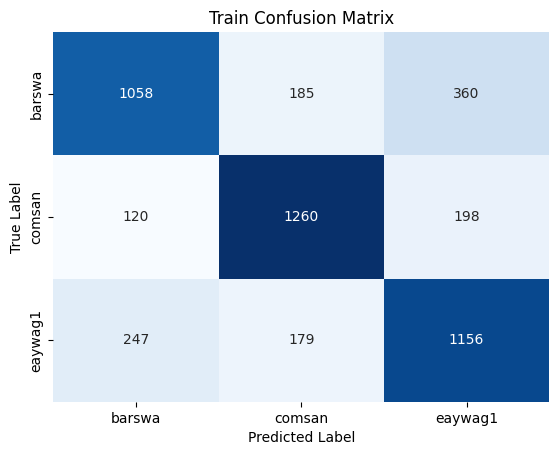

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

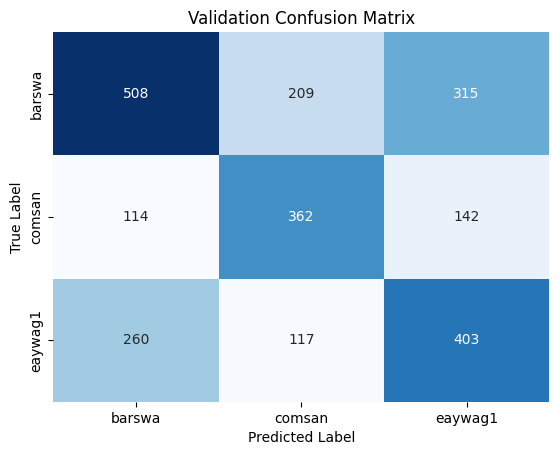

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only RMS & Spectral_Centroid

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=1)

training_features

array([[0.03010871, 0.5348336 ],
       [0.04310095, 0.6005906 ],
       [0.01226025, 0.513116  ],
       ...,
       [0.02157044, 0.3892467 ],
       [0.03071099, 0.23238704],
       [0.06832775, 0.5647373 ]], dtype=float32)

In [ ]:
training_features.shape

(4763, 2)

In [ ]:
validation_features = np.concatenate((audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=1)

validation_features

array([[0.00820298, 0.505941  ],
       [0.01806734, 0.50134593],
       [0.0407758 , 0.22624998],
       ...,
       [0.00797562, 0.43336898],
       [0.00487425, 0.32053483],
       [0.06438877, 0.210341  ]], dtype=float32)

In [ ]:
validation_features.shape

(2430, 2)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['rms_spectral_centroid'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['rms_spectral_centroid'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.44719714465672894
Validation accuracy: 0.37325102880658434


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.45      0.32      0.37      1603
      comsan       0.51      0.40      0.45      1578
     eaywag1       0.41      0.62      0.50      1582

    accuracy                           0.45      4763
   macro avg       0.46      0.45      0.44      4763
weighted avg       0.46      0.45      0.44      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.54      0.23      0.32      1032
      comsan       0.36      0.45      0.40       618
     eaywag1       0.32      0.50      0.39       780

    accuracy                           0.37      2430
   macro avg       0.41      0.39      0.37      2430
weighted avg       0.42      0.37      0.36      2430



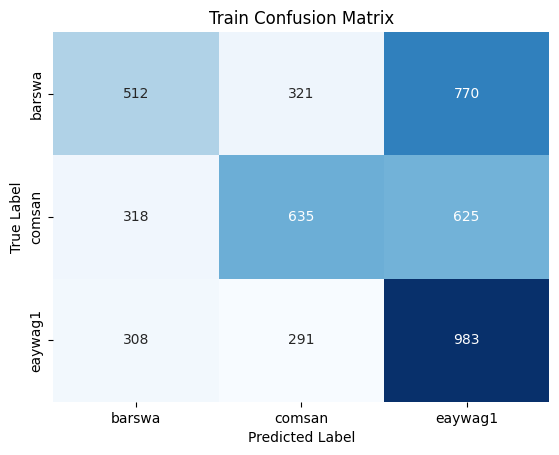

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

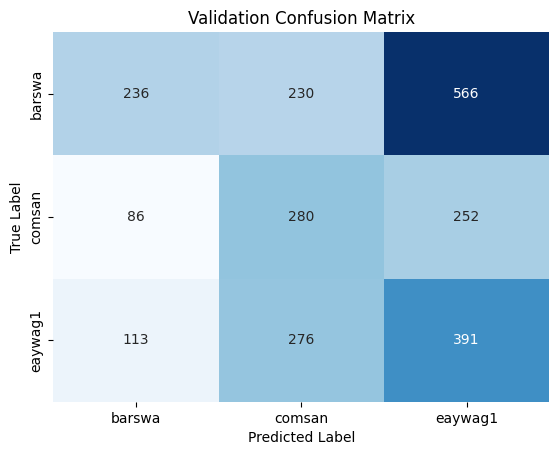

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only melspectrogram

### create features

In [ ]:
training_features = audio_df['train']['melspectrogram']

training_features

array([[0.49377877, 0.39760292, 0.37509203, ..., 0.39508733, 0.38260147,
        0.33644804],
       [0.67453784, 0.5866982 , 0.5616628 , ..., 0.6141897 , 0.64370984,
        0.63254166],
       [0.4703445 , 0.4982434 , 0.49582908, ..., 0.45155504, 0.44082302,
        0.39136806],
       ...,
       [0.7311818 , 0.67120975, 0.6472154 , ..., 0.4890181 , 0.5064263 ,
        0.51864785],
       [0.7374405 , 0.7513923 , 0.7228083 , ..., 0.44508708, 0.39849004,
        0.3597183 ],
       [0.71962327, 0.75753236, 0.73968595, ..., 0.6718846 , 0.6957295 ,
        0.7122123 ]], dtype=float32)

In [ ]:
training_features.shape

(4763, 20)

In [ ]:
validation_features = audio_df['val']['melspectrogram']

validation_features

array([[0.4351601 , 0.4388159 , 0.48237723, ..., 0.42133147, 0.43071166,
        0.4305815 ],
       [0.41609687, 0.49877998, 0.53342366, ..., 0.56695396, 0.51322293,
        0.3904866 ],
       [0.7593011 , 0.77988636, 0.7575733 , ..., 0.46728382, 0.42231834,
        0.38794464],
       ...,
       [0.6064124 , 0.53587633, 0.51456815, ..., 0.40604618, 0.40763697,
        0.40993348],
       [0.59300494, 0.6052985 , 0.5827291 , ..., 0.32657227, 0.30032754,
        0.2806743 ],
       [0.7965588 , 0.79531133, 0.7845649 , ..., 0.44813597, 0.4773222 ,
        0.44515556]], dtype=float32)

In [ ]:
validation_features.shape

(2430, 20)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.820911190426202
Validation accuracy: 0.5592592592592592


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.88      0.81      0.84      1603
      comsan       0.89      0.82      0.85      1578
     eaywag1       0.72      0.84      0.78      1582

    accuracy                           0.82      4763
   macro avg       0.83      0.82      0.82      4763
weighted avg       0.83      0.82      0.82      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.70      0.56      0.63      1032
      comsan       0.54      0.60      0.57       618
     eaywag1       0.44      0.52      0.48       780

    accuracy                           0.56      2430
   macro avg       0.56      0.56      0.56      2430
weighted avg       0.58      0.56      0.56      2430



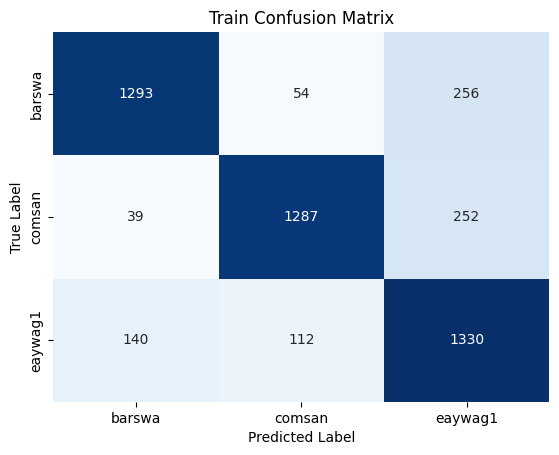

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

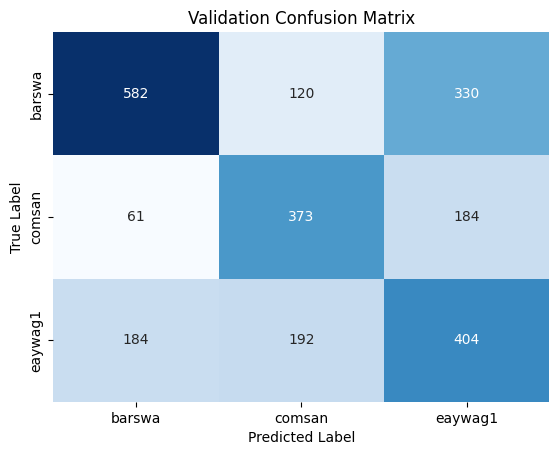

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.34820727, 0.48184183, 0.64611143, ..., 1.        , 0.        ,
        0.        ],
       [0.64404237, 0.45292035, 0.62639439, ..., 0.        , 0.        ,
        0.        ],
       [0.46427891, 0.51910329, 0.47646573, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.62084126, 0.60520083, 0.62595576, ..., 1.        , 0.        ,
        0.        ],
       [0.67159772, 0.72349191, 0.40953511, ..., 0.        , 1.        ,
        0.        ],
       [0.78831404, 0.52622873, 0.58111882, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
training_features.shape

(4763, 25)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.4809289 , 0.48404783, 0.46143031, ..., 0.        , 1.        ,
        0.        ],
       [0.52836245, 0.4776704 , 0.37530428, ..., 0.        , 1.        ,
        0.        ],
       [0.70113063, 0.72963738, 0.42718813, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.47892618, 0.58912402, 0.59166372, ..., 0.        , 1.        ,
        0.        ],
       [0.42351782, 0.66250044, 0.61499703, ..., 0.        , 0.        ,
        0.        ],
       [0.68570822, 0.77514535, 0.51776344, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(2430, 25)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8062145706487508
Validation accuracy: 0.6802469135802469


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.90      0.78      0.83      1603
      comsan       0.78      0.88      0.83      1578
     eaywag1       0.75      0.76      0.76      1582

    accuracy                           0.81      4763
   macro avg       0.81      0.81      0.81      4763
weighted avg       0.81      0.81      0.81      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.80      0.66      0.72      1032
      comsan       0.66      0.70      0.68       618
     eaywag1       0.59      0.70      0.64       780

    accuracy                           0.68      2430
   macro avg       0.68      0.68      0.68      2430
weighted avg       0.70      0.68      0.68      2430



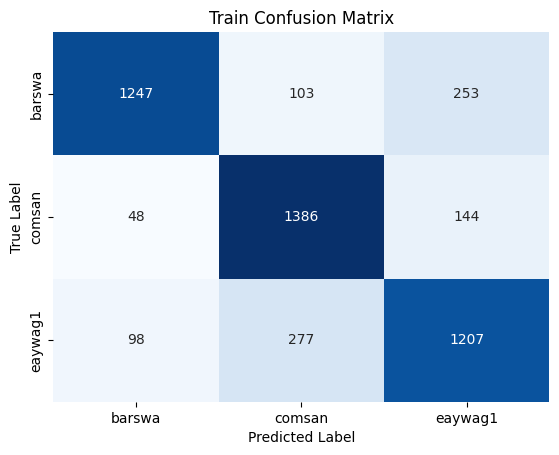

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

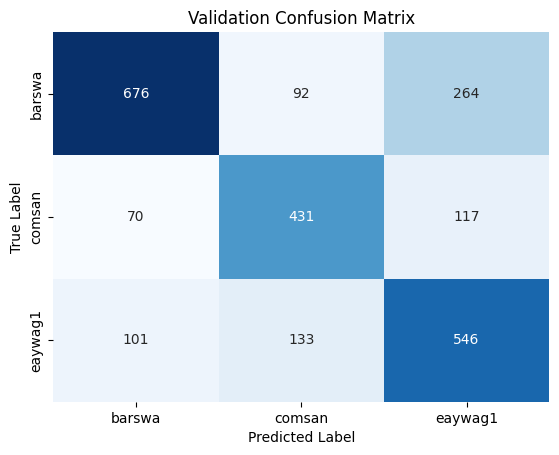

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & chroma

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'],), axis=1)

training_features

array([[0.34820727, 0.48184183, 0.6461114 , ..., 0.32982287, 0.27211753,
        0.26353404],
       [0.6440424 , 0.45292035, 0.6263944 , ..., 0.5029362 , 0.42173085,
        0.37840915],
       [0.4642789 , 0.5191033 , 0.47646573, ..., 0.403861  , 0.32589912,
        0.32983282],
       ...,
       [0.62084126, 0.6052008 , 0.62595576, ..., 0.7229928 , 0.6785163 ,
        0.6189387 ],
       [0.6715977 , 0.7234919 , 0.4095351 , ..., 0.7976932 , 0.7712831 ,
        0.77631885],
       [0.78831404, 0.5262287 , 0.5811188 , ..., 0.77093816, 0.8106363 ,
        0.7499701 ]], dtype=float32)

In [ ]:
training_features.shape

(4763, 32)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma']), axis=1)

validation_features

array([[0.4809289 , 0.48404783, 0.4614303 , ..., 0.6026752 , 0.5844439 ,
        0.5068333 ],
       [0.52836245, 0.4776704 , 0.37530428, ..., 0.2732252 , 0.38316128,
        0.3078552 ],
       [0.7011306 , 0.7296374 , 0.42718813, ..., 0.76596546, 0.71478146,
        0.7406465 ],
       ...,
       [0.47892618, 0.589124  , 0.5916637 , ..., 0.63181746, 0.61438715,
        0.5792776 ],
       [0.42351782, 0.66250044, 0.614997  , ..., 0.57986253, 0.7078528 ,
        0.682594  ],
       [0.6857082 , 0.77514535, 0.51776344, ..., 0.5295637 , 0.55182225,
        0.6297107 ]], dtype=float32)

In [ ]:
validation_features.shape

(2430, 32)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_chroma'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_chroma'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.9399538106235565
Validation accuracy: 0.6831275720164609


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.96      0.91      0.93      1603
      comsan       0.96      0.95      0.96      1578
     eaywag1       0.90      0.96      0.93      1582

    accuracy                           0.94      4763
   macro avg       0.94      0.94      0.94      4763
weighted avg       0.94      0.94      0.94      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.76      0.65      0.70      1032
      comsan       0.65      0.74      0.69       618
     eaywag1       0.63      0.68      0.65       780

    accuracy                           0.68      2430
   macro avg       0.68      0.69      0.68      2430
weighted avg       0.69      0.68      0.68      2430



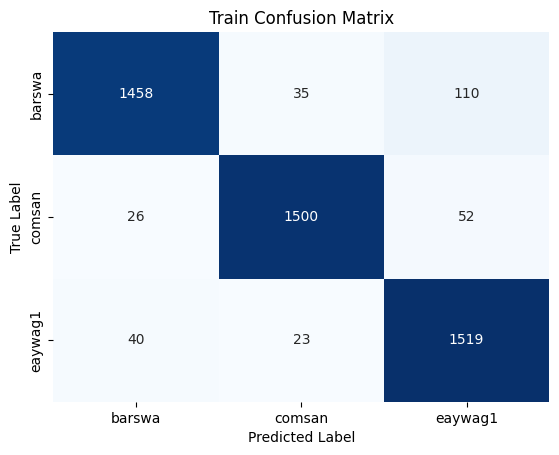

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

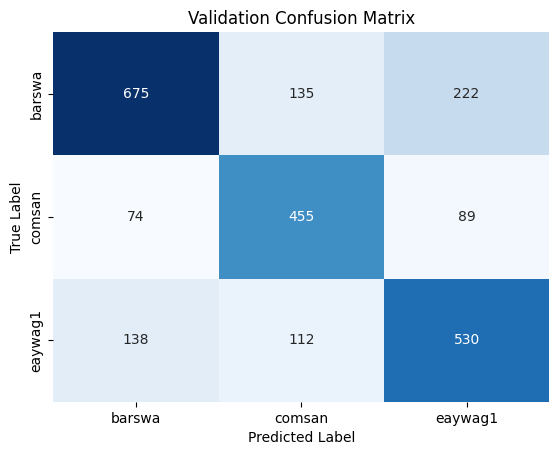

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & chroma & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.34820727, 0.48184183, 0.64611143, ..., 1.        , 0.        ,
        0.        ],
       [0.64404237, 0.45292035, 0.62639439, ..., 0.        , 0.        ,
        0.        ],
       [0.46427891, 0.51910329, 0.47646573, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.62084126, 0.60520083, 0.62595576, ..., 1.        , 0.        ,
        0.        ],
       [0.67159772, 0.72349191, 0.40953511, ..., 0.        , 1.        ,
        0.        ],
       [0.78831404, 0.52622873, 0.58111882, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
training_features.shape

(4763, 37)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.4809289 , 0.48404783, 0.46143031, ..., 0.        , 1.        ,
        0.        ],
       [0.52836245, 0.4776704 , 0.37530428, ..., 0.        , 1.        ,
        0.        ],
       [0.70113063, 0.72963738, 0.42718813, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.47892618, 0.58912402, 0.59166372, ..., 0.        , 1.        ,
        0.        ],
       [0.42351782, 0.66250044, 0.61499703, ..., 0.        , 0.        ,
        0.        ],
       [0.68570822, 0.77514535, 0.51776344, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(2430, 37)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_chroma_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_chroma_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8681503254251522
Validation accuracy: 0.7234567901234568


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.93      0.84      0.88      1603
      comsan       0.87      0.90      0.89      1578
     eaywag1       0.81      0.86      0.84      1582

    accuracy                           0.87      4763
   macro avg       0.87      0.87      0.87      4763
weighted avg       0.87      0.87      0.87      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.82      0.71      0.76      1032
      comsan       0.67      0.73      0.70       618
     eaywag1       0.66      0.73      0.70       780

    accuracy                           0.72      2430
   macro avg       0.72      0.73      0.72      2430
weighted avg       0.73      0.72      0.73      2430



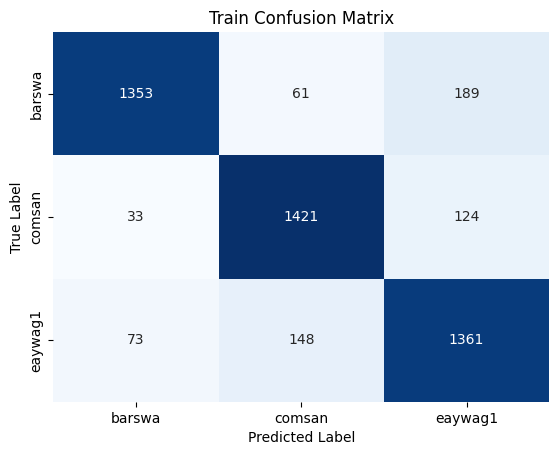

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

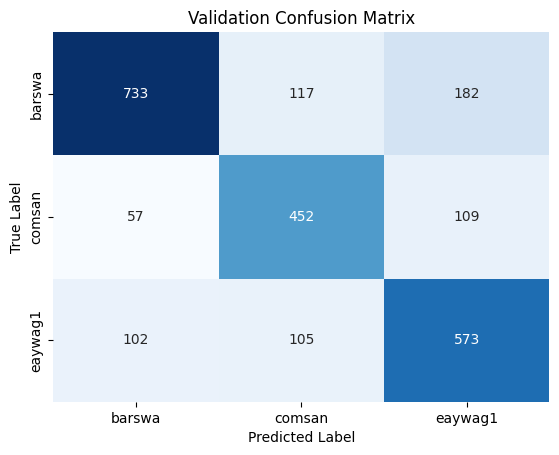

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & rms & spectral_centroid

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=1)

training_features

array([[0.34820727, 0.48184183, 0.6461114 , ..., 0.48694566, 0.03010871,
        0.5348336 ],
       [0.6440424 , 0.45292035, 0.6263944 , ..., 0.468493  , 0.04310095,
        0.6005906 ],
       [0.4642789 , 0.5191033 , 0.47646573, ..., 0.4301965 , 0.01226025,
        0.513116  ],
       ...,
       [0.62084126, 0.6052008 , 0.62595576, ..., 0.48378655, 0.02157044,
        0.3892467 ],
       [0.6715977 , 0.7234919 , 0.4095351 , ..., 0.4582841 , 0.03071099,
        0.23238704],
       [0.78831404, 0.5262287 , 0.5811188 , ..., 0.44815272, 0.06832775,
        0.5647373 ]], dtype=float32)

In [ ]:
training_features.shape

(4763, 22)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=1)

validation_features

array([[0.4809289 , 0.48404783, 0.4614303 , ..., 0.5255967 , 0.00820298,
        0.505941  ],
       [0.52836245, 0.4776704 , 0.37530428, ..., 0.49824807, 0.01806734,
        0.50134593],
       [0.7011306 , 0.7296374 , 0.42718813, ..., 0.44203296, 0.0407758 ,
        0.22624998],
       ...,
       [0.47892618, 0.589124  , 0.5916637 , ..., 0.50978327, 0.00797562,
        0.43336898],
       [0.42351782, 0.66250044, 0.614997  , ..., 0.42415786, 0.00487425,
        0.32053483],
       [0.6857082 , 0.77514535, 0.51776344, ..., 0.4648098 , 0.06438877,
        0.210341  ]], dtype=float32)

In [ ]:
validation_features.shape

(2430, 22)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_rms_spectral_centroid'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_rms_spectral_centroid'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8868360277136259
Validation accuracy: 0.648559670781893


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.91      0.85      0.88      1603
      comsan       0.93      0.89      0.91      1578
     eaywag1       0.83      0.92      0.87      1582

    accuracy                           0.89      4763
   macro avg       0.89      0.89      0.89      4763
weighted avg       0.89      0.89      0.89      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.69      0.67      0.68      1032
      comsan       0.63      0.67      0.65       618
     eaywag1       0.61      0.60      0.61       780

    accuracy                           0.65      2430
   macro avg       0.64      0.65      0.65      2430
weighted avg       0.65      0.65      0.65      2430



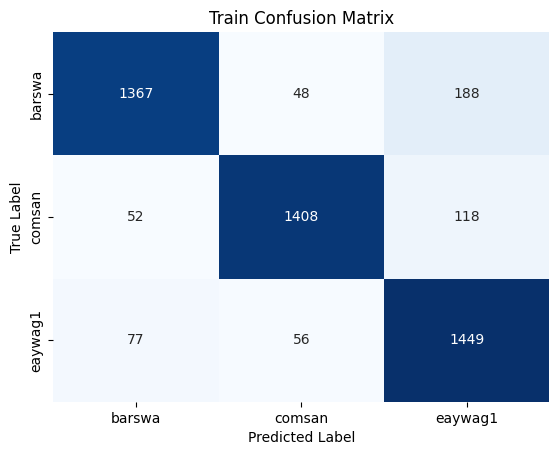

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

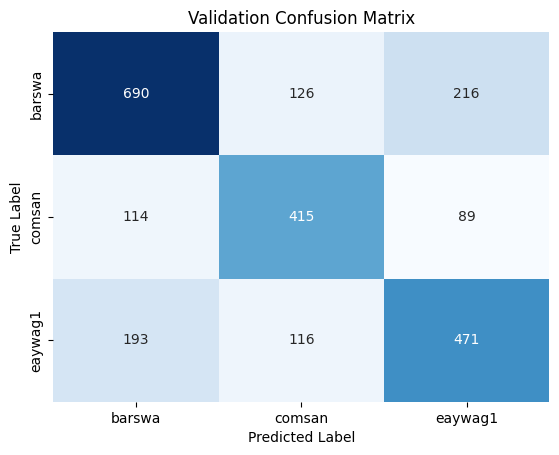

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & rms & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.34820727, 0.48184183, 0.64611143, ..., 1.        , 0.        ,
        0.        ],
       [0.64404237, 0.45292035, 0.62639439, ..., 0.        , 0.        ,
        0.        ],
       [0.46427891, 0.51910329, 0.47646573, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.62084126, 0.60520083, 0.62595576, ..., 1.        , 0.        ,
        0.        ],
       [0.67159772, 0.72349191, 0.40953511, ..., 0.        , 1.        ,
        0.        ],
       [0.78831404, 0.52622873, 0.58111882, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
training_features.shape

(4763, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['rms'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.4809289 , 0.48404783, 0.46143031, ..., 0.        , 1.        ,
        0.        ],
       [0.52836245, 0.4776704 , 0.37530428, ..., 0.        , 1.        ,
        0.        ],
       [0.70113063, 0.72963738, 0.42718813, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.47892618, 0.58912402, 0.59166372, ..., 0.        , 1.        ,
        0.        ],
       [0.42351782, 0.66250044, 0.61499703, ..., 0.        , 0.        ,
        0.        ],
       [0.68570822, 0.77514535, 0.51776344, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(2430, 26)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_rms_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_rms_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8089439428931345
Validation accuracy: 0.6868312757201646


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.89      0.79      0.84      1603
      comsan       0.79      0.88      0.83      1578
     eaywag1       0.75      0.76      0.76      1582

    accuracy                           0.81      4763
   macro avg       0.81      0.81      0.81      4763
weighted avg       0.81      0.81      0.81      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.81      0.65      0.72      1032
      comsan       0.68      0.71      0.69       618
     eaywag1       0.59      0.72      0.65       780

    accuracy                           0.69      2430
   macro avg       0.69      0.69      0.69      2430
weighted avg       0.70      0.69      0.69      2430



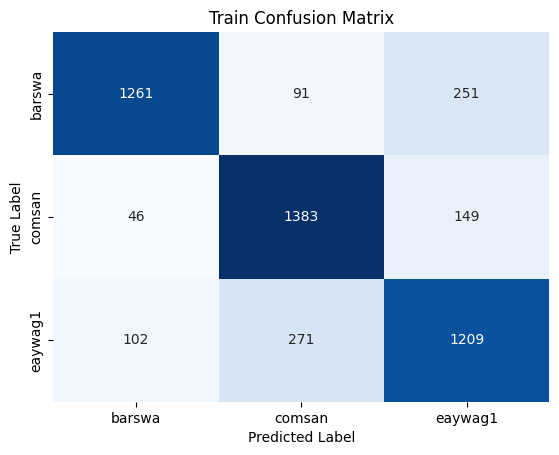

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

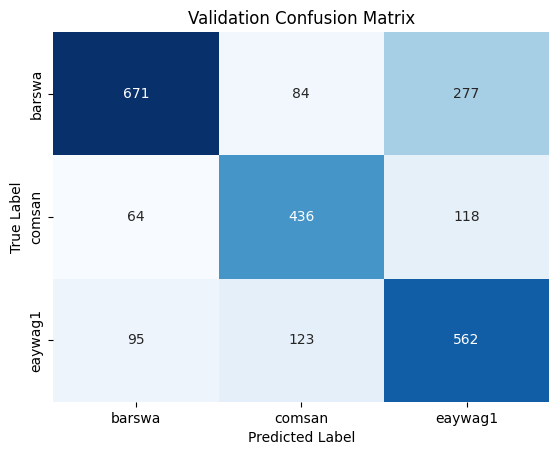

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & spectral_centroid & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['spectral_centroid'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.34820727, 0.48184183, 0.64611143, ..., 1.        , 0.        ,
        0.        ],
       [0.64404237, 0.45292035, 0.62639439, ..., 0.        , 0.        ,
        0.        ],
       [0.46427891, 0.51910329, 0.47646573, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.62084126, 0.60520083, 0.62595576, ..., 1.        , 0.        ,
        0.        ],
       [0.67159772, 0.72349191, 0.40953511, ..., 0.        , 1.        ,
        0.        ],
       [0.78831404, 0.52622873, 0.58111882, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
training_features.shape

(4763, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['spectral_centroid'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.4809289 , 0.48404783, 0.46143031, ..., 0.        , 1.        ,
        0.        ],
       [0.52836245, 0.4776704 , 0.37530428, ..., 0.        , 1.        ,
        0.        ],
       [0.70113063, 0.72963738, 0.42718813, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.47892618, 0.58912402, 0.59166372, ..., 0.        , 1.        ,
        0.        ],
       [0.42351782, 0.66250044, 0.61499703, ..., 0.        , 0.        ,
        0.        ],
       [0.68570822, 0.77514535, 0.51776344, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(2430, 26)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['mfcc_spectral_centroid_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['mfcc_spectral_centroid_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8139827839596893
Validation accuracy: 0.6934156378600823


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.90      0.79      0.84      1603
      comsan       0.78      0.89      0.83      1578
     eaywag1       0.77      0.77      0.77      1582

    accuracy                           0.81      4763
   macro avg       0.82      0.81      0.81      4763
weighted avg       0.82      0.81      0.81      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.82      0.68      0.74      1032
      comsan       0.65      0.70      0.68       618
     eaywag1       0.60      0.71      0.65       780

    accuracy                           0.69      2430
   macro avg       0.69      0.70      0.69      2430
weighted avg       0.71      0.69      0.70      2430



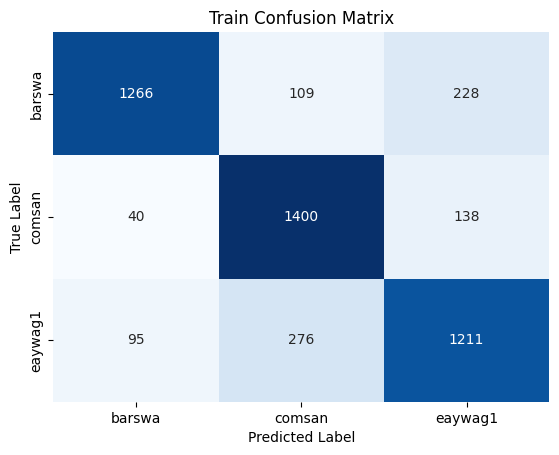

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

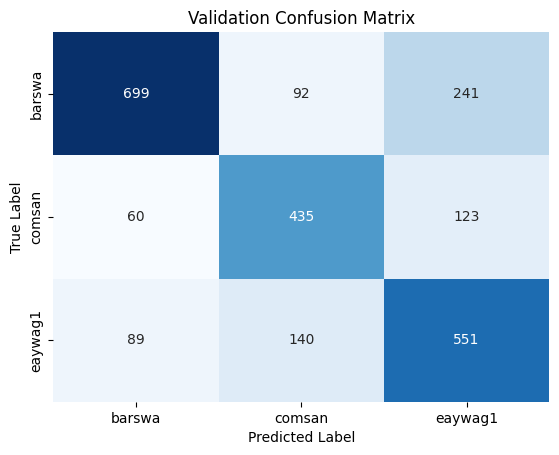

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & chroma

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['chroma']), axis=1)

training_features

array([[0.49377877, 0.39760292, 0.37509203, ..., 0.32982287, 0.27211753,
        0.26353404],
       [0.67453784, 0.5866982 , 0.5616628 , ..., 0.5029362 , 0.42173085,
        0.37840915],
       [0.4703445 , 0.4982434 , 0.49582908, ..., 0.403861  , 0.32589912,
        0.32983282],
       ...,
       [0.7311818 , 0.67120975, 0.6472154 , ..., 0.7229928 , 0.6785163 ,
        0.6189387 ],
       [0.7374405 , 0.7513923 , 0.7228083 , ..., 0.7976932 , 0.7712831 ,
        0.77631885],
       [0.71962327, 0.75753236, 0.73968595, ..., 0.77093816, 0.8106363 ,
        0.7499701 ]], dtype=float32)

In [ ]:
training_features.shape

(4763, 32)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['chroma']), axis=1)

validation_features

array([[0.4351601 , 0.4388159 , 0.48237723, ..., 0.6026752 , 0.5844439 ,
        0.5068333 ],
       [0.41609687, 0.49877998, 0.53342366, ..., 0.2732252 , 0.38316128,
        0.3078552 ],
       [0.7593011 , 0.77988636, 0.7575733 , ..., 0.76596546, 0.71478146,
        0.7406465 ],
       ...,
       [0.6064124 , 0.53587633, 0.51456815, ..., 0.63181746, 0.61438715,
        0.5792776 ],
       [0.59300494, 0.6052985 , 0.5827291 , ..., 0.57986253, 0.7078528 ,
        0.682594  ],
       [0.7965588 , 0.79531133, 0.7845649 , ..., 0.5295637 , 0.55182225,
        0.6297107 ]], dtype=float32)

In [ ]:
validation_features.shape

(2430, 32)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram_chroma'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram_chroma'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.9122401847575058
Validation accuracy: 0.6185185185185185


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.92      0.90      0.91      1603
      comsan       0.94      0.92      0.93      1578
     eaywag1       0.87      0.92      0.90      1582

    accuracy                           0.91      4763
   macro avg       0.91      0.91      0.91      4763
weighted avg       0.91      0.91      0.91      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.74      0.60      0.66      1032
      comsan       0.56      0.65      0.60       618
     eaywag1       0.55      0.62      0.59       780

    accuracy                           0.62      2430
   macro avg       0.62      0.62      0.62      2430
weighted avg       0.63      0.62      0.62      2430



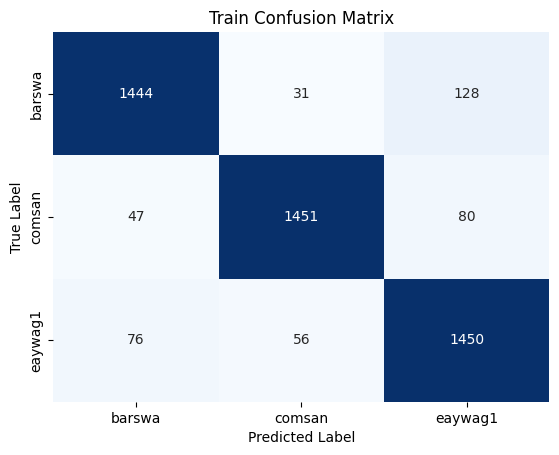

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

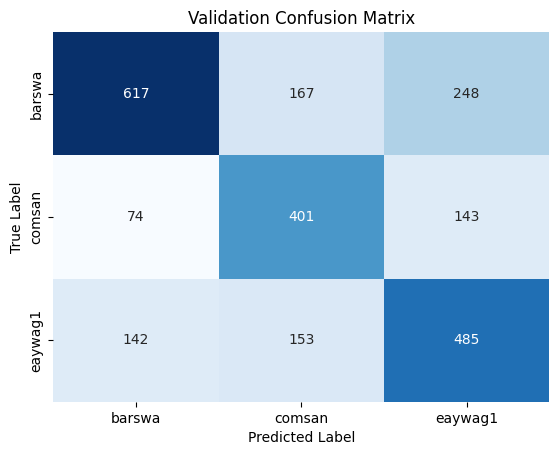

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & chroma & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['chroma'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.49377877, 0.39760292, 0.37509203, ..., 1.        , 0.        ,
        0.        ],
       [0.67453784, 0.58669817, 0.56166279, ..., 0.        , 0.        ,
        0.        ],
       [0.47034451, 0.49824339, 0.49582908, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.7311818 , 0.67120975, 0.64721543, ..., 1.        , 0.        ,
        0.        ],
       [0.73744053, 0.7513923 , 0.7228083 , ..., 0.        , 1.        ,
        0.        ],
       [0.71962327, 0.75753236, 0.73968595, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
training_features.shape

(4763, 37)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['chroma'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.4351601 , 0.43881589, 0.48237723, ..., 0.        , 1.        ,
        0.        ],
       [0.41609687, 0.49877998, 0.53342366, ..., 0.        , 1.        ,
        0.        ],
       [0.75930113, 0.77988636, 0.75757331, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.60641241, 0.53587633, 0.51456815, ..., 0.        , 1.        ,
        0.        ],
       [0.59300494, 0.60529852, 0.5827291 , ..., 0.        , 0.        ,
        0.        ],
       [0.7965588 , 0.79531133, 0.78456491, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(2430, 37)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram_chroma_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram_chroma_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8557631744698719
Validation accuracy: 0.6777777777777778


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.92      0.82      0.87      1603
      comsan       0.90      0.85      0.87      1578
     eaywag1       0.77      0.90      0.83      1582

    accuracy                           0.86      4763
   macro avg       0.86      0.86      0.86      4763
weighted avg       0.86      0.86      0.86      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.82      0.66      0.73      1032
      comsan       0.62      0.69      0.65       618
     eaywag1       0.59      0.69      0.64       780

    accuracy                           0.68      2430
   macro avg       0.68      0.68      0.67      2430
weighted avg       0.70      0.68      0.68      2430



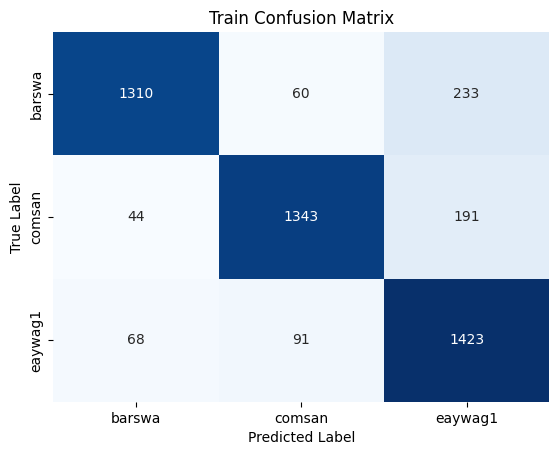

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

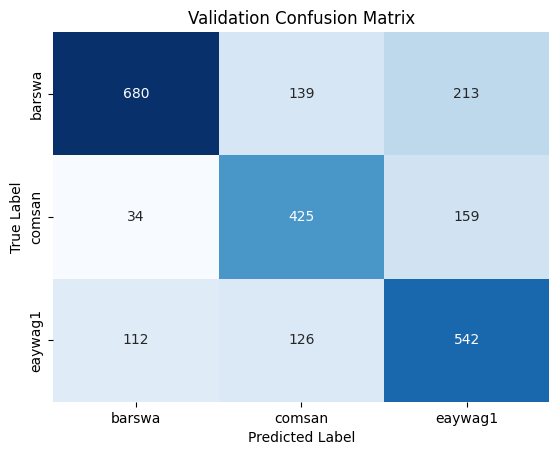

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & rms & spectral_centroid

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=1)

training_features

array([[0.49377877, 0.39760292, 0.37509203, ..., 0.33644804, 0.03010871,
        0.5348336 ],
       [0.67453784, 0.5866982 , 0.5616628 , ..., 0.63254166, 0.04310095,
        0.6005906 ],
       [0.4703445 , 0.4982434 , 0.49582908, ..., 0.39136806, 0.01226025,
        0.513116  ],
       ...,
       [0.7311818 , 0.67120975, 0.6472154 , ..., 0.51864785, 0.02157044,
        0.3892467 ],
       [0.7374405 , 0.7513923 , 0.7228083 , ..., 0.3597183 , 0.03071099,
        0.23238704],
       [0.71962327, 0.75753236, 0.73968595, ..., 0.7122123 , 0.06832775,
        0.5647373 ]], dtype=float32)

In [ ]:
training_features.shape

(4763, 22)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=1)

validation_features

array([[0.4351601 , 0.4388159 , 0.48237723, ..., 0.4305815 , 0.00820298,
        0.505941  ],
       [0.41609687, 0.49877998, 0.53342366, ..., 0.3904866 , 0.01806734,
        0.50134593],
       [0.7593011 , 0.77988636, 0.7575733 , ..., 0.38794464, 0.0407758 ,
        0.22624998],
       ...,
       [0.6064124 , 0.53587633, 0.51456815, ..., 0.40993348, 0.00797562,
        0.43336898],
       [0.59300494, 0.6052985 , 0.5827291 , ..., 0.2806743 , 0.00487425,
        0.32053483],
       [0.7965588 , 0.79531133, 0.7845649 , ..., 0.44515556, 0.06438877,
        0.210341  ]], dtype=float32)

In [ ]:
validation_features.shape

(2430, 22)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram_rms_spectral_centroid'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram_rms_spectral_centroid'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.8028553432710477
Validation accuracy: 0.5679012345679012


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.85      0.80      0.82      1603
      comsan       0.88      0.79      0.83      1578
     eaywag1       0.70      0.82      0.76      1582

    accuracy                           0.80      4763
   macro avg       0.81      0.80      0.80      4763
weighted avg       0.81      0.80      0.80      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.70      0.58      0.64      1032
      comsan       0.53      0.60      0.57       618
     eaywag1       0.46      0.52      0.49       780

    accuracy                           0.57      2430
   macro avg       0.57      0.57      0.56      2430
weighted avg       0.58      0.57      0.57      2430



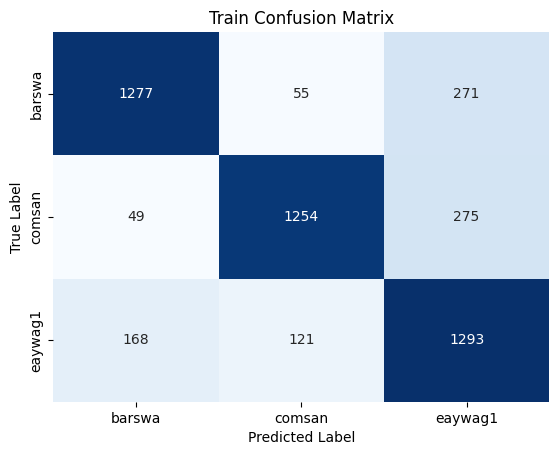

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

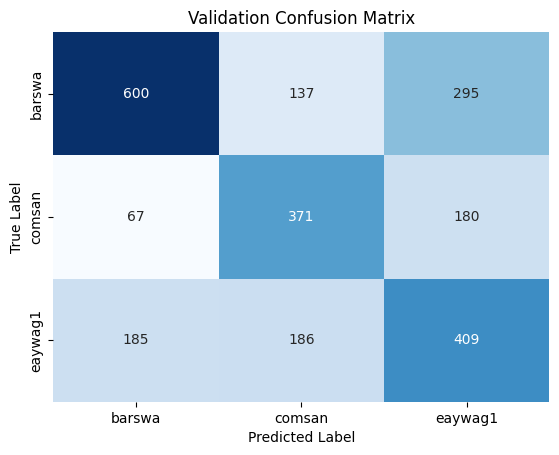

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & rms & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['rms'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.49377877, 0.39760292, 0.37509203, ..., 1.        , 0.        ,
        0.        ],
       [0.67453784, 0.58669817, 0.56166279, ..., 0.        , 0.        ,
        0.        ],
       [0.47034451, 0.49824339, 0.49582908, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.7311818 , 0.67120975, 0.64721543, ..., 1.        , 0.        ,
        0.        ],
       [0.73744053, 0.7513923 , 0.7228083 , ..., 0.        , 1.        ,
        0.        ],
       [0.71962327, 0.75753236, 0.73968595, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
training_features.shape

(4763, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['rms'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.4351601 , 0.43881589, 0.48237723, ..., 0.        , 1.        ,
        0.        ],
       [0.41609687, 0.49877998, 0.53342366, ..., 0.        , 1.        ,
        0.        ],
       [0.75930113, 0.77988636, 0.75757331, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.60641241, 0.53587633, 0.51456815, ..., 0.        , 1.        ,
        0.        ],
       [0.59300494, 0.60529852, 0.5827291 , ..., 0.        , 0.        ,
        0.        ],
       [0.7965588 , 0.79531133, 0.78456491, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(2430, 26)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram_rms_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram_rms_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.7627545664497166
Validation accuracy: 0.5946502057613169


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.90      0.67      0.77      1603
      comsan       0.85      0.77      0.81      1578
     eaywag1       0.63      0.85      0.72      1582

    accuracy                           0.76      4763
   macro avg       0.79      0.76      0.77      4763
weighted avg       0.79      0.76      0.77      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.81      0.51      0.63      1032
      comsan       0.58      0.63      0.60       618
     eaywag1       0.48      0.68      0.56       780

    accuracy                           0.59      2430
   macro avg       0.62      0.61      0.60      2430
weighted avg       0.64      0.59      0.60      2430



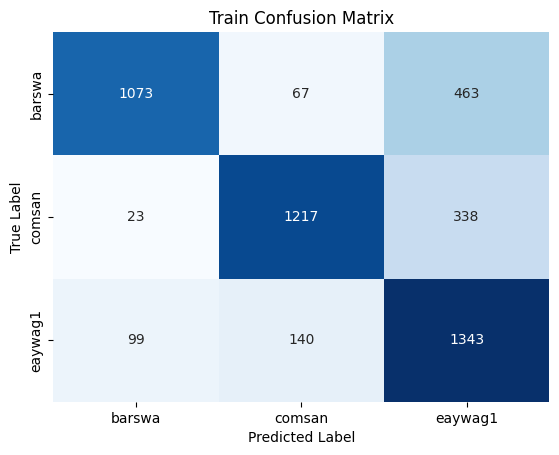

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

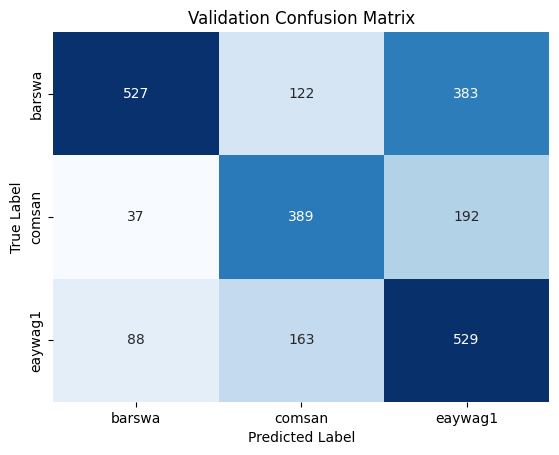

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & spectral_centroid & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['spectral_centroid'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.49377877, 0.39760292, 0.37509203, ..., 1.        , 0.        ,
        0.        ],
       [0.67453784, 0.58669817, 0.56166279, ..., 0.        , 0.        ,
        0.        ],
       [0.47034451, 0.49824339, 0.49582908, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.7311818 , 0.67120975, 0.64721543, ..., 1.        , 0.        ,
        0.        ],
       [0.73744053, 0.7513923 , 0.7228083 , ..., 0.        , 1.        ,
        0.        ],
       [0.71962327, 0.75753236, 0.73968595, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
training_features.shape

(4763, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['spectral_centroid'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.4351601 , 0.43881589, 0.48237723, ..., 0.        , 1.        ,
        0.        ],
       [0.41609687, 0.49877998, 0.53342366, ..., 0.        , 1.        ,
        0.        ],
       [0.75930113, 0.77988636, 0.75757331, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.60641241, 0.53587633, 0.51456815, ..., 0.        , 1.        ,
        0.        ],
       [0.59300494, 0.60529852, 0.5827291 , ..., 0.        , 0.        ,
        0.        ],
       [0.7965588 , 0.79531133, 0.78456491, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(2430, 26)

### fit the model with training data

In [ ]:
model = SVC(kernel='rbf', C=4)
model.fit(training_features, audio_df['train']['label'])

SVC(C=4)

In [ ]:
print('Training accuracy:', model.score(training_features, audio_df['train']['label']))
train_results['melspectrogram_spectral_centroid_continents'] = model.score(training_features, audio_df['train']['label'])

print('Validation accuracy:', model.score(validation_features, audio_df['val']['label']))
val_results['melspectrogram_spectral_centroid_continents'] = model.score(validation_features, audio_df['val']['label'])

Training accuracy: 0.7644341801385681
Validation accuracy: 0.5921810699588478


### evaluate the results

In [ ]:
train_yhat_result = model.predict(training_features)

print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.89      0.71      0.79      1603
      comsan       0.83      0.77      0.80      1578
     eaywag1       0.64      0.82      0.72      1582

    accuracy                           0.76      4763
   macro avg       0.79      0.76      0.77      4763
weighted avg       0.79      0.76      0.77      4763



In [ ]:
val_yhat_result = model.predict(validation_features)

print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.78      0.53      0.63      1032
      comsan       0.58      0.60      0.59       618
     eaywag1       0.48      0.67      0.56       780

    accuracy                           0.59      2430
   macro avg       0.61      0.60      0.59      2430
weighted avg       0.63      0.59      0.60      2430



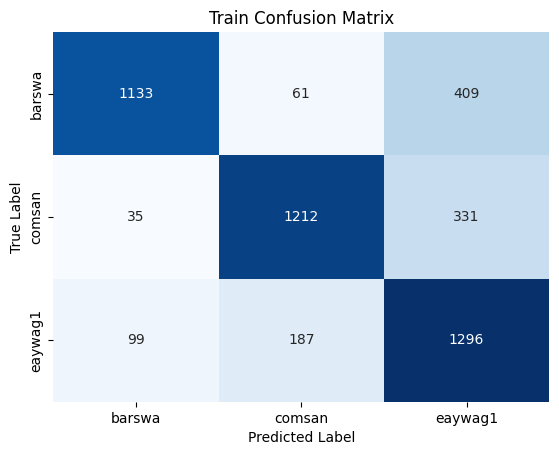

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

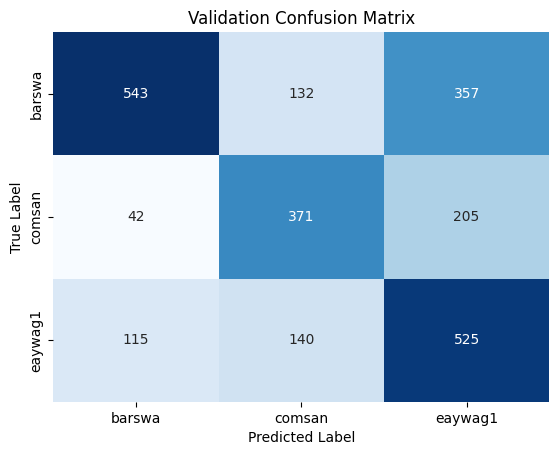

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

# Review results from all models

In [ ]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Val_Accuracy')
result_df

,Features,Train_Accuracy,Val_Accuracy
3,rms_spectral_centroid,0.45,0.37
2,chroma,0.73,0.52
4,melspectrogram,0.82,0.56
13,melspectrogram_rms_spectral_centroid,0.80,0.57
14,melspectrogram_rms_continents,0.76,0.59
15,melspectrogram_spectral_centroid_continents,0.76,0.59
11,melspectrogram_chroma,0.91,0.62
1,mfcc,0.93,0.63
8,mfcc_rms_spectral_centroid,0.89,0.65
5,mfcc_continents,0.81,0.68
